In [1]:
import os
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from torchvision.ops.boxes import box_iou
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pandas as pd
from glob import glob

In [2]:
TYPES = [
    "pedestrians", 
    "two_wheelers"
]

In [3]:
class COSMOSDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform = None):
        self.root = root 
        self.raw_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])
        self.transforms = transforms.Compose(self.raw_transforms.transforms + transform.transforms)
        self.types = TYPES
        self.images = []
        self.labels = []
        for label, class_name in enumerate(self.types):
            class_dir = os.path.join(root, class_name + "_resized_64")
        for img_file in os.listdir(root):
            if img_file.endswith('.jpg') or img_file.endswith('.png'):  
                self.images.append(os.path.join(root, img_file))
                self.labels.append(int(img_file[-5]))
                    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, label
    
    def __len__(self):
        return len(self.images)

In [4]:
scale = (224, 224)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = transforms.Compose([
    transforms.Resize(scale, antialias=True),
    transforms.Normalize(mean, std)
])

root = r"C:\Users\aishw\Documents\Columbia_MS_EE\Fall_2023\Sparse_Models_For_High_Dimensional_Data\Project\github\e6876-project\custom_COSMOS_annotation\CVAT_Patches\test"
dataset = COSMOSDataset(root, transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

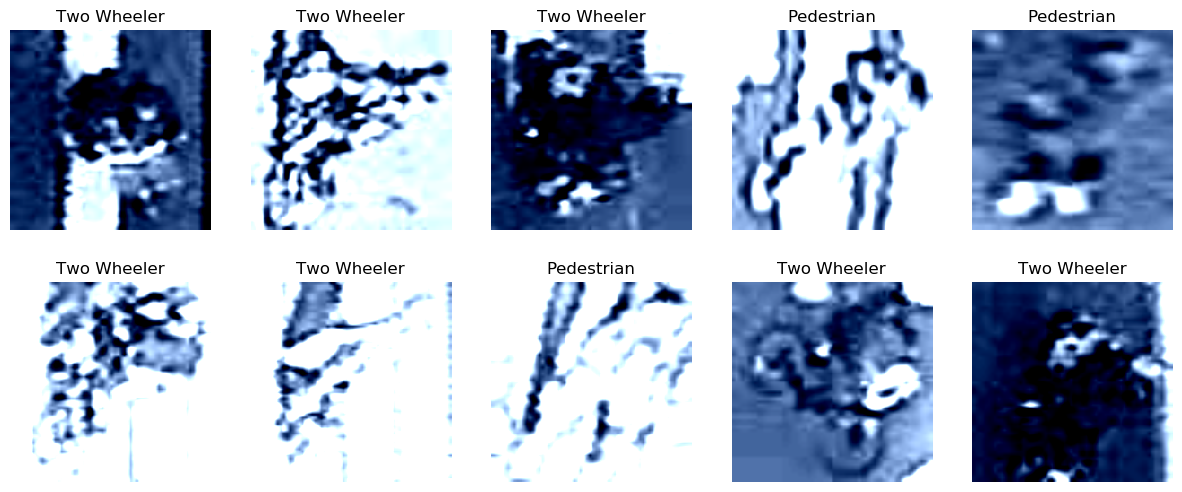

In [5]:
idx = np.random.choice(range(len(dataset)), 10, replace=False)
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
class_names = ['Pedestrian', 'Two Wheeler']
for i, index in enumerate(idx):
    image, label = dataset[index]
    image_np = image.numpy().transpose(1, 2, 0) 
    title = class_names[label - 1]

    ax[i // 5, i % 5].imshow(image_np)
    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].set_title(title)

plt.show() 

## Features

In [6]:
from torchvision.models import resnet50, ResNet50_Weights

class Featurizer(nn.Module):
    def __init__(self, model, weights, num_layers=6):
        super().__init__()
        model = model(weights=weights)
        # To register a list of nn.Modules, wrap them up with nn.ModuleList:
        # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html
        # Compared to nn.Sequential that seals the modules as one, nn.ModuleList
        # provides easier access to intermediate layers
        self.layers = nn.ModuleList(list(model.children()))
        self.num_layers = num_layers

    def forward(self, x):
        # feed forward through a specific number of layers
        for layer in self.layers[:self.num_layers]:
            x = layer(x)
        return x

In [7]:
len(dataset)

946

In [8]:
featurizer = Featurizer(resnet50, ResNet50_Weights.DEFAULT, -1).cuda()
Xt, yt = dataset[idx[1]]
featurizer.eval()
feat = featurizer(Xt.cuda().unsqueeze(0))
print(Xt.shape, feat.shape)

torch.Size([3, 224, 224]) torch.Size([1, 2048, 1, 1])


In [9]:
root = r".\CVAT_Patches\\"
root_train = r".\CVAT_Patches\train"
root_test = r".\CVAT_Patches\test"
transform = transforms.Compose([
    transforms.Resize(scale, antialias=True),
    transforms.Normalize(mean, std)
])
train_set = COSMOSDataset(root_train, transform)
test_set = COSMOSDataset(root_test, transform)
len(train_set), len(test_set)

(1101, 946)

In [10]:
feats = []
labels = []
featurizer.eval()
for i, (X, y) in enumerate(train_set):
    ped = X.unsqueeze(0).cuda()
    feats.append(featurizer(ped).detach().squeeze().cpu().numpy())
    labels.append(y - 1)
feats = np.stack(feats)
labels = np.stack(labels)
np.save(root + 'train_feats_new.npy', feats)
np.save(root + 'train_labels_new.npy', labels)
print(feats.shape, labels.shape)

feats = []
labels = []
for i, (X, y) in enumerate(test_set):
    ped = X.unsqueeze(0).cuda()
    feats.append(featurizer(ped).detach().squeeze().cpu().numpy())
    labels.append(y - 1)
feats = np.stack(feats)
labels = np.stack(labels)
np.save(root + 'test_feats_new.npy', feats)
np.save(root + 'test_labels_new.npy', labels)
print(feats.shape, labels.shape)

(1101, 2048) (1101,)
(946, 2048) (946,)


In [11]:
from glob import glob
import numpy as np
root = r".\CVAT_Patches\\"
train_imgs = sorted(glob(root + 'train\\*.jpg'))
test_imgs = sorted(glob(root + 'test\\*.jpg'))
len(train_imgs), len(test_imgs)

(1101, 946)

In [12]:
train_dict = []
for i in train_imgs:
    train_dict.append(np.array(Image.open(i)))

test_dict = []
for i in test_imgs:
    test_dict.append(np.array(Image.open(i)))

train_dict = np.stack(train_dict, axis=0)
test_dict = np.stack(test_dict, axis=0)

mean = np.mean(train_dict, axis=0)
std = np.std(train_dict, axis=0)

eps = 1e-5
train_dict = (train_dict - mean) / std
test_dict = (test_dict - mean) / std

train_dict.shape, test_dict.shape

((1101, 64, 64), (946, 64, 64))

In [13]:
np.save(root + 'train_dict_new.npy', train_dict)
np.save(root + 'test_dict_new.npy', test_dict)